In [178]:
# standard
import pandas as pd
import numpy as np
import random
import os
import math

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection  import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

#silence TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Setting random seeds
random.seed(0)
np.random.seed(0)
tf.keras.backend.clear_session()
tf.random.set_seed(0)

### new section with player names

#### read in data from data4 (just X and Y) and split into train/val/test

In [83]:
# read in data
x = pd.read_csv("data4/X.csv").drop(columns=['Unnamed: 0'])
y = pd.read_csv("data4/Y.csv").drop(columns=['Unnamed: 0'])

# get dummies for all categorical variables
cat_columns = ['season', 'player_team_name', 'opp_team_name', 'opp_diff_ind', 'position', 'GW', 'was_home', 'name_normalized']
x_encoded = pd.get_dummies(x, columns = cat_columns)

# get index for 2018-21 train, 2021-22 val, 2022-23 test split
x_2018_2021_index = x.index[x['season'].isin(['2018-19','2019-20','2020-21'])].tolist()
x_2021_2022_index = x.index[x['season'].isin(['2021-22'])].tolist()
x_2022_2023_index = x.index[x['season'].isin(['2022-23'])].tolist()

# get data for 2018-21 train, 2021-22 val, 2022-23 test split
x_train_2018_21 = x_encoded.iloc[x_2018_2021_index]
x_val_2021_22 = x_encoded.iloc[x_2021_2022_index]
x_test_2022_23 = x_encoded.iloc[x_2022_2023_index]
y_train_2018_21 = y.iloc[x_2018_2021_index].drop(columns=['season'])
y_val_2021_22 = y.iloc[x_2021_2022_index].drop(columns=['season'])
y_test_2022_23 = y.iloc[x_2022_2023_index].drop(columns=['season'])

#### no validation split needed for KNN actually, so just split into train/test
maybe can delete section right above later

In [92]:
# read in data
x = pd.read_csv("data4/X.csv").drop(columns=['Unnamed: 0'])
y = pd.read_csv("data4/Y.csv").drop(columns=['Unnamed: 0'])

# get dummies for all categorical variables
cat_columns = ['season', 'player_team_name', 'opp_team_name', 'opp_diff_ind', 'position', 'GW', 'was_home', 'name_normalized']
x_encoded = pd.get_dummies(x, columns = cat_columns)

# get index for 2018-21 train, 2021-22 val, 2022-23 test split
x_2018_2022_index = x.index[x['season'].isin(['2018-19','2019-20','2020-21','2021-22'])].tolist()
x_2022_2023_index = x.index[x['season'].isin(['2022-23'])].tolist()

# get data for 2018-21 train, 2021-22 val, 2022-23 test split
x_train_2018_22 = x_encoded.iloc[x_2018_2022_index]
x_test_2022_23 = x_encoded.iloc[x_2022_2023_index]
y_train_2018_22 = y.iloc[x_2018_2022_index].drop(columns=['season'])
y_test_2022_23 = y.iloc[x_2022_2023_index].drop(columns=['season'])

#### baseline

In [91]:
# calculate baseline
baseline = y_train_2018_21.total_points.mean()

# compute RMSE of baseline on test and train data
mse_train = np.square(np.subtract(y_train_2018_21.total_points , baseline)).mean()
mse_val = np.square(np.subtract(y_val_2021_22.total_points , baseline)).mean()
mse_test = np.square(np.subtract(y_test_2022_23.total_points , baseline)).mean()

print(f"train MSE: {mse_train}")
print(f"val MSE: {mse_val}")
print(f"test MSE: {mse_test}")

train MSE: 6.302880420704537
val MSE: 6.02675090957298
test MSE: 5.573325945935219


#### different variable combination possibilities

In [109]:
# Column combination possibilities
all_cols = x_train_2018_22.columns

lag_1 = ['assists_lag_1', 'bonus_lag_1', 'bps_lag_1', 'clean_sheets_lag_1',
       'creativity_lag_1', 'goals_conceded_lag_1', 'goals_scored_lag_1',
       'ict_index_lag_1', 'influence_lag_1', 'minutes_lag_1',
       'own_goals_lag_1', 'penalties_missed_lag_1', 'penalties_saved_lag_1',
       'red_cards_lag_1', 'saves_lag_1', 'selected_lag_1',
       'player_team_score_lag_1', 'opp_team_score_lag_1', 'threat_lag_1',
       'total_points_lag_1', 'value_lag_1', 'yellow_cards_lag_1']

lag_3 = ['assists_lag_3', 'bonus_lag_3', 'bps_lag_3', 'clean_sheets_lag_3',
       'creativity_lag_3', 'goals_conceded_lag_3', 'goals_scored_lag_3',
       'ict_index_lag_3', 'influence_lag_3', 'minutes_lag_3',
       'own_goals_lag_3', 'penalties_missed_lag_3', 'penalties_saved_lag_3',
       'red_cards_lag_3', 'saves_lag_3', 'selected_lag_3',
       'player_team_score_lag_3', 'opp_team_score_lag_3', 'threat_lag_3',
       'total_points_lag_3', 'value_lag_3', 'yellow_cards_lag_3']

lag_5 = ['assists_lag_5', 'bonus_lag_5', 'bps_lag_5', 'clean_sheets_lag_5',
       'creativity_lag_5', 'goals_conceded_lag_5', 'goals_scored_lag_5',
       'ict_index_lag_5', 'influence_lag_5', 'minutes_lag_5',
       'own_goals_lag_5', 'penalties_missed_lag_5', 'penalties_saved_lag_5',
       'red_cards_lag_5', 'saves_lag_5', 'selected_lag_5',
       'player_team_score_lag_5', 'opp_team_score_lag_5', 'threat_lag_5',
       'total_points_lag_5', 'value_lag_5', 'yellow_cards_lag_5']

# Create subset of features based on lag
lag1_features = list(set(all_cols) - set(lag_3) - set(lag_5))
lag3_features = list(set(all_cols) - set(lag_1) - set(lag_5))
lag5_features = list(set(all_cols) - set(lag_1) - set(lag_3))

# create different possibilities of train and test based on which lag is chosen
x_train_lag1 = x_train_2018_22[lag1_features]
x_train_lag3 = x_train_2018_22[lag3_features]
x_train_lag5 = x_train_2018_22[lag5_features]

x_test_lag1 = x_test_2022_23[lag1_features]
x_test_lag3 = x_test_2022_23[lag3_features]
x_test_lag5 = x_test_2022_23[lag5_features]

#### knn modeling

In [123]:
def run_knn(k, df_x_train, df_x_test, y_train, y_test, cv=10):
    
    # running for different K values to know which yields the max accuracy.
    scores=[]
    for K in range(k):   
        K = K+1
        clf = KNeighborsRegressor(n_neighbors = K)
        clf.fit(df_x_train, y_train)
        score = cross_val_score(clf, df_x_train, y_train, cv=10)
        scores.append(score.mean())
        print(f"k={K} mse: {1 - score.mean()}")
    
    mse = [1-x for x in scores]
    optimal_k = mse.index(min(mse)) + 1
    print("Optimal K: ", optimal_k)
    
    # Training the model on Optimal K.
    clf_optimal = KNeighborsRegressor(n_neighbors = optimal_k)
    clf_optimal.fit(df_x_train, y_train)
    y_pred = clf_optimal.predict(df_x_test)
    print("MSE Error: ", mean_squared_error(y_test, y_pred))

    return mse

#### trial of function

In [124]:
run_knn(1, x_train_lag1, x_test_lag1, y_train_2018_22, y_test_2022_23)

k=1 mse: 1.3205967046037645
Optimal K:  1
MSE Error:  8.093906810035842


[1.3205967046037645]

#### run function for the different datasets

In [127]:
# run for lag 1 data
print("lag 1 results: ")
mse_lag1 = run_knn(20, x_train_lag1, x_test_lag1, y_train_2018_22, y_test_2022_23)

lag 1 results: 
k=1 mse: 1.3205967046037645
k=2 mse: 1.006487195622321
k=3 mse: 0.9103415570474163
k=4 mse: 0.8649854432234526
k=5 mse: 0.8373378857913416
k=6 mse: 0.818495981024069
k=7 mse: 0.8056512820799687
k=8 mse: 0.798924663504905
k=9 mse: 0.7935161616282979
k=10 mse: 0.7883684235367434
k=11 mse: 0.7826660393139011
k=12 mse: 0.7797402180061004
k=13 mse: 0.7760438071121845
k=14 mse: 0.7729816441268472
k=15 mse: 0.7707369643775319
k=16 mse: 0.7678452385088453
k=17 mse: 0.7662204338197056
k=18 mse: 0.7639150030090925
k=19 mse: 0.761926516996524
k=20 mse: 0.7601296185895565
Optimal K:  20
MSE Error:  4.159767213733258


In [128]:
# run for lag 3 data
print("lag 3 results: \n")
mse_lag2 = run_knn(20, x_train_lag3, x_test_lag3, y_train_2018_22, y_test_2022_23)

lag 3 results: 

k=1 mse: 1.368850855402974
k=2 mse: 1.0352891326665636
k=3 mse: 0.9301800583005557
k=4 mse: 0.8786106957568237
k=5 mse: 0.8491166411331876
k=6 mse: 0.8278443777421614
k=7 mse: 0.8127799191010556
k=8 mse: 0.8029356876099526
k=9 mse: 0.7943097544633055
k=10 mse: 0.7878740308419111
k=11 mse: 0.7817815914757552
k=12 mse: 0.7780690002093527
k=13 mse: 0.7739216737337982
k=14 mse: 0.7704594959924048
k=15 mse: 0.7678803026564831
k=16 mse: 0.7660642325383
k=17 mse: 0.7644783896674971
k=18 mse: 0.76288455172829
k=19 mse: 0.7610111517551357
k=20 mse: 0.759929397410826
Optimal K:  20
MSE Error:  4.140466704395397


In [129]:
# run for lag 5 data
print("lag 5 results: \n")
mse_lag3 = run_knn(20, x_train_lag5, x_test_lag5, y_train_2018_22, y_test_2022_23)

lag 5 results: 

k=1 mse: 1.3730471358012908
k=2 mse: 1.0462445278165722
k=3 mse: 0.9427051326037452
k=4 mse: 0.8869957642364827
k=5 mse: 0.8543918386235595
k=6 mse: 0.8326526346905732
k=7 mse: 0.8181703078348874
k=8 mse: 0.8079844866705106
k=9 mse: 0.8009712364209229
k=10 mse: 0.7947893097755729
k=11 mse: 0.7902647179431904
k=12 mse: 0.785948283227794
k=13 mse: 0.7811138731179007
k=14 mse: 0.7786088071985982
k=15 mse: 0.7763402163755881
k=16 mse: 0.7743751618913154
k=17 mse: 0.7722665541308886
k=18 mse: 0.7707897791448188
k=19 mse: 0.7686642569272989
k=20 mse: 0.7674547382858276
Optimal K:  20
MSE Error:  4.210868326730806


In [133]:
# run for all data
print("all lag results: \n")
mse_lag_all = run_knn(20, x_train_2018_22, x_test_2022_23, y_train_2018_22, y_test_2022_23)

all lag results: 

k=1 mse: 1.3570350970379108
k=2 mse: 1.0336211373934396
k=3 mse: 0.9250616371078758
k=4 mse: 0.8717853562975727
k=5 mse: 0.8433798480227248
k=6 mse: 0.8241115677007951
k=7 mse: 0.8096374292645377
k=8 mse: 0.8003899581407745
k=9 mse: 0.7942524983180195
k=10 mse: 0.7863527825254495
k=11 mse: 0.7809282571595415
k=12 mse: 0.7771634963237991
k=13 mse: 0.7744695442913383
k=14 mse: 0.7713396330086956
k=15 mse: 0.7679912938933602
k=16 mse: 0.7653627233838673
k=17 mse: 0.7632592859953237
k=18 mse: 0.761130919883367
k=19 mse: 0.7593867735008113
k=20 mse: 0.7574478373169767
Optimal K:  20
MSE Error:  4.082206376155442


#### get MAE as well as MSE

In [182]:
# k=20 performed the best for all of them
clf_optimal = KNeighborsRegressor(n_neighbors = 20)

# get mse and mae of lag1 data
print("lag_1 data: ")
clf_optimal.fit(x_train_lag1, y_train_2018_22)
y_pred = clf_optimal.predict(x_test_lag1)
print("MSE Error: ", mean_squared_error(y_test_2022_23, y_pred))
print("MAE Error: ", mean_absolute_error(y_test_2022_23, y_pred))

# get mse and mae of lag3 data
print("\nlag_3 data: ")
clf_optimal.fit(x_train_lag3, y_train_2018_22)
y_pred = clf_optimal.predict(x_test_lag3)
print("MSE Error: ", mean_squared_error(y_test_2022_23, y_pred))
print("MAE Error: ", mean_absolute_error(y_test_2022_23, y_pred))

# get mse and mae of lag5 data
print("\nlag_5 data: ")
clf_optimal.fit(x_train_lag5, y_train_2018_22)
y_pred = clf_optimal.predict(x_test_lag5)
print("MSE Error: ", mean_squared_error(y_test_2022_23, y_pred))
print("MAE Error: ", mean_absolute_error(y_test_2022_23, y_pred))

# get mse and mae of all data
print("\nall data: ")
clf_optimal.fit(x_train_2018_22, y_train_2018_22)
y_pred = clf_optimal.predict(x_test_2022_23)
print("MSE Error: ", mean_squared_error(y_test_2022_23, y_pred))
print("MAE Error: ", mean_absolute_error(y_test_2022_23, y_pred))

lag_1 data: 
MSE Error:  4.159767213733258
MAE Error:  1.1247387285417845

lag_3 data: 
MSE Error:  4.140466704395397
MAE Error:  1.0954725523486135

lag_5 data: 
MSE Error:  4.210868326730806
MAE Error:  1.104731182795699

all data: 
MSE Error:  4.082206376155442
MAE Error:  1.0676400679117148


#### Train MSE by K

In [172]:
#range_k = range(1,21)
dict = {'k': list(range(1,21)), 'lag1 mse': mse_lag1, 'lag3 mse': mse_lag2, 'lag5 mse': mse_lag3, 'all mse': mse_lag_all}
pd.DataFrame(dict)

,k,lag1 mse,lag3 mse,lag5 mse,all mse
0,1,1.320597,1.368851,1.373047,1.357035
1,2,1.006487,1.035289,1.046245,1.033621
2,3,0.910342,0.930180,0.942705,0.925062
3,4,0.864985,0.878611,0.886996,0.871785
4,5,0.837338,0.849117,0.854392,0.843380
5,6,0.818496,0.827844,0.832653,0.824112
6,7,0.805651,0.812780,0.818170,0.809637
7,8,0.798925,0.802936,0.807984,0.800390
8,9,0.793516,0.794310,0.800971,0.794252
9,10,0.788368,0.787874,0.794789,0.786353


#### test mse and mae for best k in training

In [181]:
data = ['lag_1', 'lag_3', 'lag_5', 'all']
mse = [4.159767213733258, 4.140466704395397, 4.210868326730806, 4.082206376155442]
mae = [1.1247387285417845, 1.0954725523486135, 1.104731182795699, 1.0676400679117148]

dict = {'data': data, 'test mse': mse, 'test mae': mae} 
df_2018_23_player_name = pd.DataFrame(dict)
df_2018_23_player_name

,data,test mse,test mae
0,lag_1,4.159767,1.124739
1,lag_3,4.140467,1.095473
2,lag_5,4.210868,1.104731
3,all,4.082206,1.067640


#### Graph out MSE vs K for different datasets for training

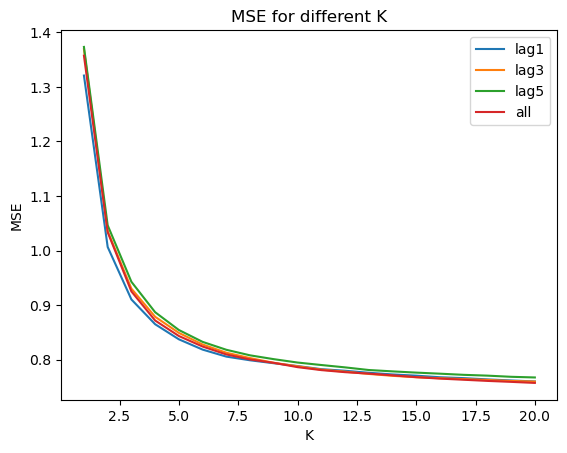

In [155]:
plt.plot(range(1,21), mse_lag1, label='lag1')
plt.plot(range(1,21), mse_lag2, label='lag3')
plt.plot(range(1,21), mse_lag3, label='lag5')
plt.plot(range(1,21), mse_lag_all, label='all')
plt.title("MSE for different K")
plt.xlabel("K")
plt.ylabel("MSE")
plt.legend()
plt.savefig('MSE_player_names_included.png')
plt.show()

## section for modeling done on all player names ends here

#### read in data

In [67]:
# read in data
x_train = pd.read_csv("data3/X_train.csv").drop(columns=['Unnamed: 0'])
y_train = pd.read_csv("data3/Y_train.csv").drop(columns=['Unnamed: 0'])
x_val = pd.read_csv("data3/X_val.csv").drop(columns=['Unnamed: 0'])
y_val = pd.read_csv("data3/Y_val.csv").drop(columns=['Unnamed: 0'])
x_test = pd.read_csv("data3/X_test.csv").drop(columns=['Unnamed: 0'])
y_test = pd.read_csv("data3/Y_test.csv").drop(columns=['Unnamed: 0'])

In [69]:
x_train

,season,player_team_name,opp_team_name,opp_diff_ind,position,GW,was_home,name_normalized,assists_lag_1,bonus_lag_1,...,penalties_saved_lag_5,red_cards_lag_5,saves_lag_5,selected_lag_5,player_team_score_lag_5,opp_team_score_lag_5,threat_lag_5,total_points_lag_5,value_lag_5,yellow_cards_lag_5
0,2018-19,West Ham,Liverpool,4,DEF,1,False,aaron cresswell,-0.184964,-0.215403,...,-0.048352,-0.093734,-0.177503,-0.409936,-1.808301,-1.899736,-0.529878,-0.752585,-3.373454,-0.430582
1,2018-19,West Ham,Bournemouth,1,DEF,2,True,aaron cresswell,-0.184964,-0.215403,...,-0.048352,-0.093734,-0.177503,-0.155985,-1.808301,3.816565,-0.529878,-0.752585,0.329490,-0.430582
2,2018-19,West Ham,Arsenal,4,DEF,3,False,aaron cresswell,-0.184964,-0.215403,...,-0.048352,-0.093734,-0.177503,-0.170799,-1.121215,2.387490,-0.529878,-0.752585,0.329490,-0.430582
3,2018-19,West Ham,Wolves,2,DEF,4,True,aaron cresswell,-0.184964,-0.215403,...,-0.048352,-0.093734,-0.177503,-0.193770,-0.892187,2.387490,-0.529878,-0.752585,0.307048,-0.430582
4,2018-19,West Ham,Everton,2,DEF,5,False,aaron cresswell,-0.184964,-0.215403,...,-0.048352,-0.093734,-0.177503,-0.212392,-1.121215,1.672952,-0.529878,-0.611039,0.278995,1.677694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68786,2020-21,Aston Villa,Man Utd,3,GK,35,True,rjan nyland,-0.184964,-0.215403,...,-0.048352,-0.093734,-0.177503,0.287310,0.665207,0.386784,-0.529878,-0.752585,-0.680404,-0.430582
68787,2020-21,Aston Villa,Everton,2,GK,35,True,rjan nyland,-0.184964,-0.215403,...,-0.048352,-0.093734,-0.177503,0.281039,0.115539,0.958415,-0.529878,-0.752585,-0.680404,-0.430582
68788,2020-21,Aston Villa,Crystal Palace,2,GK,36,False,rjan nyland,-0.184964,-0.215403,...,-0.048352,-0.093734,-0.177503,0.276369,-0.159296,0.386784,-0.529878,-0.752585,-0.680404,-0.430582
68789,2020-21,Aston Villa,Spurs,3,GK,37,False,rjan nyland,-0.184964,-0.215403,...,-0.048352,-0.093734,-0.177503,0.272210,0.115539,0.672600,-0.529878,-0.752585,-0.680404,-0.430582


In [ ]:
x_all = pd.concat([x_train, x_val, x_test])
cat_columns = ['season', 'player_team_name', 'opp_team_name', 'opp_diff_ind', 'position', 'GW', 'was_home', 'name_normalized']
x_all_encoded = pd.get_dummies(x_all, columns = cat_columns)

#### read in data
data1 directory has dense one-hot encodings <br>
data2 directory has sparse one-hot encodings <br>
data3 directory is same as data2 but with player name <br>
data4 directory has just X and Y so that we can split train/val/test by different seasons

In [2]:
# read in data
x_train = pd.read_csv("data2/X_train.csv").drop(columns=['Unnamed: 0'])
y_train = pd.read_csv("data2/Y_train.csv").drop(columns=['Unnamed: 0'])
x_val = pd.read_csv("data2/X_val.csv").drop(columns=['Unnamed: 0'])
y_val = pd.read_csv("data2/Y_val.csv").drop(columns=['Unnamed: 0'])
x_test = pd.read_csv("data2/X_test.csv").drop(columns=['Unnamed: 0'])
y_test = pd.read_csv("data2/Y_test.csv").drop(columns=['Unnamed: 0'])

In [66]:
x_all = pd.concat([x_train, x_val, x_test])
cat_columns = ['season', 'player_team_name', 'opp_team_name', 'opp_diff_ind', 'position', 'GW', 'was_home']
x_all_encoded = pd.get_dummies(x_all, columns = cat_columns)

(120743, 73)

#### Baseline

In [3]:
# calculate baseline
baseline = y_train.total_points.mean()

# compute RMSE of baseline on test and train data
mse_train = np.square(np.subtract(y_train.total_points , baseline)).mean()
mse_test = np.square(np.subtract(y_test.total_points , baseline)).mean()

print(f"train MSE: {mse_train}")
print(f"test MSE: {mse_test}")

train MSE: 6.302880420704537
test MSE: 5.573325945935219


#### KNN Model

In [11]:
# Column combination possibilities

all_cols = x_train.columns

lag_1 = ['assists_lag_1', 'bonus_lag_1', 'bps_lag_1', 'clean_sheets_lag_1',
       'creativity_lag_1', 'goals_conceded_lag_1', 'goals_scored_lag_1',
       'ict_index_lag_1', 'influence_lag_1', 'minutes_lag_1',
       'own_goals_lag_1', 'penalties_missed_lag_1', 'penalties_saved_lag_1',
       'red_cards_lag_1', 'saves_lag_1', 'selected_lag_1',
       'player_team_score_lag_1', 'opp_team_score_lag_1', 'threat_lag_1',
       'total_points_lag_1', 'value_lag_1', 'yellow_cards_lag_1']

lag_3 = ['assists_lag_3', 'bonus_lag_3', 'bps_lag_3', 'clean_sheets_lag_3',
       'creativity_lag_3', 'goals_conceded_lag_3', 'goals_scored_lag_3',
       'ict_index_lag_3', 'influence_lag_3', 'minutes_lag_3',
       'own_goals_lag_3', 'penalties_missed_lag_3', 'penalties_saved_lag_3',
       'red_cards_lag_3', 'saves_lag_3', 'selected_lag_3',
       'player_team_score_lag_3', 'opp_team_score_lag_3', 'threat_lag_3',
       'total_points_lag_3', 'value_lag_3', 'yellow_cards_lag_3']

lag_5 = ['assists_lag_5', 'bonus_lag_5', 'bps_lag_5', 'clean_sheets_lag_5',
       'creativity_lag_5', 'goals_conceded_lag_5', 'goals_scored_lag_5',
       'ict_index_lag_5', 'influence_lag_5', 'minutes_lag_5',
       'own_goals_lag_5', 'penalties_missed_lag_5', 'penalties_saved_lag_5',
       'red_cards_lag_5', 'saves_lag_5', 'selected_lag_5',
       'player_team_score_lag_5', 'opp_team_score_lag_5', 'threat_lag_5',
       'total_points_lag_5', 'value_lag_5', 'yellow_cards_lag_5']

cat = ['season', 'player_team_name', 'opp_team_name',
       'opp_diff_ind', 'position', 'GW', 'was_home']

judgmental_imp = ['player_team_name_mapping', 'opp_team_name_mapping',
       'opp_diff_ind_mapping', 'position_mapping', 'was_home_mapping',
       'assists_lag_3', 'bonus_lag_3', 'goals_scored_lag_3', 'ict_index_lag_3',
       'minutes_lag_3', 'red_cards_lag_3', 'selected_lag_3', 'player_team_score_lag_3',
       'opp_team_score_lag_3', 'total_points_lag_3', 'value_lag_3', 'yellow_cards_lag_3'] # Uses lag 3 as a default

In [ ]:
cat_columns = ['season', 'player_team_name', 'opp_team_name',
       'opp_diff_ind', 'position', 'GW', 'was_home']
df_encoded = pd.get_dummies(x_train, columns = cat_columns)

#### run KNN model using CV to choose best K

In [56]:
def run_knn(df_x_train, df_x_test, cv=10):
    
    # running for different K values to know which yields the max accuracy.
    scores=[]
    for K in range(20):   
        K = K+1
        clf = KNeighborsRegressor(n_neighbors = K)
        clf.fit(df_x_train, y_train)
        score = cross_val_score(clf, df_x_train, y_train, cv=10)
        scores.append(score.mean())
    
    mse = [1-x for x in scores]
    optimal_k = mse.index(min(mse)) + 1
    print("Optimal K: ", optimal_k)
    
    # Training the model on Optimal K.
    clf_optimal = KNeighborsRegressor(n_neighbors = optimal_k)
    clf_optimal.fit(df_x_train, y_train)
    y_pred = clf_optimal.predict(df_x_test)
    print("MSE Error: ", mean_squared_error(y_test, y_pred))

#### this is ideal model, adding lagged variables with the categorical variables
however, right now, it's throwing an error because there's categorical variables in the test data that aren't seen in the training data...

In [ ]:
cat_columns = ['season', 'player_team_name', 'opp_team_name',
       'opp_diff_ind', 'position', 'GW', 'was_home']

df_xtrain_1 = x_train[lag_1 + cat]
df_xtest_1 = x_test[lag_1 + cat]
df_xtrain_1_encoded = pd.get_dummies(df_xtrain_1, columns = cat_columns)
df_xtest_1_encoded = pd.get_dummies(df_xtest_1, columns = cat_columns)
run_knn(df_xtrain_1, df_xtest_1, cv=10)

#### lag1 model

In [52]:
df_xtrain_1 = x_train[lag_1]
df_xtest_1 = x_test[lag_1]
run_knn(df_xtrain_1, df_xtest_1, cv=10)

Optimal K:  19
RMS Error:  4.155893859988786


#### lag3 model

In [53]:
df_xtrain_3 = x_train[lag_3]
df_xtest_3 = x_test[lag_3]
run_knn(df_xtrain_3, df_xtest_3, cv=10)

Optimal K:  19
RMS Error:  4.136794970478052


#### lag5 model

In [54]:
df_xtrain_5 = x_train[lag_5]
df_xtest_5 = x_test[lag_5]
run_knn(df_xtrain_5, df_xtest_5, cv=10)

Optimal K:  19
RMS Error:  4.247562342546564


#### all the data

In [58]:
df_xtrain_all = x_train[lag_1 + lag_3 + lag_5]
df_xtest_all = x_test[lag_1 + lag_3 + lag_5]
run_knn(df_xtrain_all, df_xtest_all, cv=10)

Optimal K:  20
MSE Error:  4.072635068854933


#### OLD: run KNN model for lag3 data 

In [ ]:
mse_val = [] #to store mse values for different k
for K in range(20):
    K = K+1
    model = KNeighborsRegressor(n_neighbors = K)
    model.fit(x_train, y_train)  #fit the model
    pred=model.predict(x_test) #make prediction on test set
    error = mean_squared_error(y_test,pred) #calculate rmse
    mse_val.append(error) #store mse values
    
min_mse_index = mse_val.index(min(mse_val))
min_mse = min(mse_val)
print('Min mse: k=', min_mse_index , 'is:', min_mse)